# Using Bayesian methods to fit HLMs with priors of varying information
Evan Edwards

## The Models

### PV1READ ~ Female + ESCS + HOMEPOS + ICTRES + (1 + ICTRES | SchoolID)

### PV1READ ~ JOYREAD + PISADIFF + SCREADCOMP + SCREADDIFF + (1|SchoolID)

### PV1READ ~ METASUM + GFOFAIL + MASTGOAL + SWBP + WORKMAST + ADAPTIVITY + COMPETE + (1|SchoolID) 

### PV1READ ~ PERFEED + TEACHINT + BELONG + (1 + TEACHINT | SchoolID)


In [1]:

# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pymc as pm
import arviz as az
from sklearn.metrics import r2_score, mean_squared_error

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
# Load dataset
PISA2018 = pd.read_csv("pisa2018.BayesBook.csv")

In [3]:
# Data processing: converting categorical values to numerical values
PISA2018['Female'] = PISA2018['Female'].replace({'Female': 1, 'Male': 0})
# Converting numerical to categorical values
PISA2018['SchoolID'] = pd.Categorical(PISA2018['SchoolID'])

In [4]:
# The models:

#PV1READ ~ Female + ESCS + HOMEPOS + ICTRES + (1 + ICTRES | SchoolID)

#PV1READ ~ JOYREAD + PISADIFF + SCREADCOMP + SCREADDIFF + (1|SchoolID)

#PV1READ ~ METASUM + GFOFAIL + MASTGOAL + SWBP + WORKMAST + ADAPTIVITY + COMPETE + (1|SchoolID) 

#PV1READ ~ PERFEED + TEACHINT + BELONG + (1 + TEACHINT | SchoolID)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta_female, beta_escs, beta_homepos, beta_ictres, sigma_school, sigma_ictres, intercept_school, random_ictres, PV1READ_sigma]


Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 118 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
Sampling: [PV1READ]


The R^2 score is: 0.24504399535047616
The MSE is: 8878.303533358841


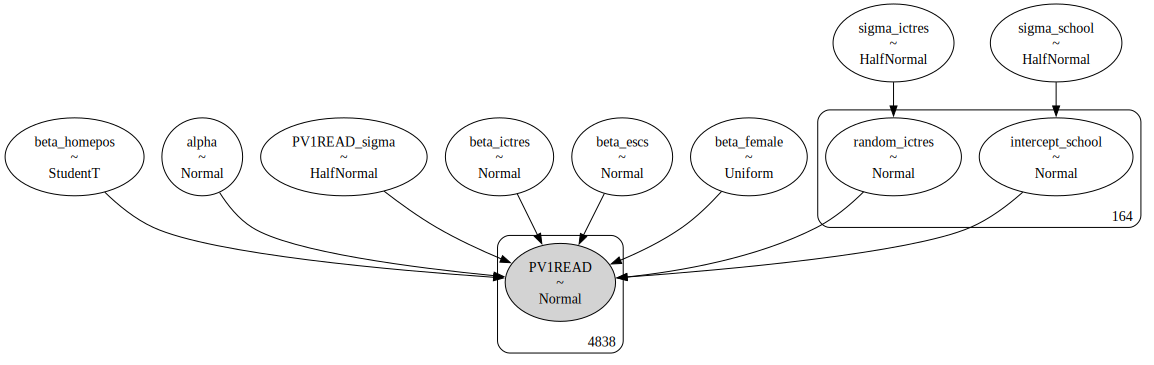

In [5]:
#PV1READ ~ Female + ESCS + HOMEPOS + ICTRES + (1 + ICTRES | SchoolID)
# Create the model
with pm.Model() as model1:
    # Priors
    alpha = pm.Normal('alpha', mu=0, sigma=100)  # Intercept
    beta_female = pm.Uniform('beta_female', lower=0, upper=1)  # Coefficient for Female
    beta_escs = pm.Normal('beta_escs', mu=np.mean(PISA2018["ESCS"]), sigma = np.std(PISA2018["ESCS"]))  # Coefficient for ESCS
    beta_homepos = pm.StudentT('beta_homepos', nu = 1,mu=np.mean(PISA2018["HOMEPOS"]), sigma=100)  # Coefficient for HOMEPOS
    beta_ictres = pm.Normal('beta_ictres', mu=np.mean(PISA2018["ICTRES"]), sigma=np.std(PISA2018["ICTRES"]))  # Coefficient for ICTRES

    # Random effects for SchoolID
    #sigma_school = pm.HalfCauchy('sigma_school', beta=10)
    sigma_school = pm.HalfNormal('sigma_school', sigma=100)
    sigma_ictres = pm.HalfNormal('sigma_ictres', sigma=100)
    intercept_school = pm.Normal('intercept_school', mu=0, sigma=sigma_school, shape=len(PISA2018["SchoolID"].unique()))
    random_ictres = pm.Normal('random_ictres', mu=0, sigma=sigma_ictres, shape=len(PISA2018["SchoolID"].unique()))

    # Likelihood equation
    PV1READ_mu = alpha + beta_female * PISA2018['Female'] + beta_escs * PISA2018['ESCS'] + beta_homepos * PISA2018['HOMEPOS']\
        + beta_ictres * PISA2018['ICTRES'] + random_ictres[PISA2018['SchoolID'].cat.codes] * PISA2018['ICTRES']  + intercept_school[PISA2018['SchoolID'].cat.codes]
    PV1READ_sigma = pm.HalfNormal('PV1READ_sigma', sigma=100)
    PV1READ = pm.Normal('PV1READ', mu=PV1READ_mu, sigma=PV1READ_sigma, observed=PISA2018['PV1READ'])
    

# Sample from the posterior distribution
with model1:
    trace = pm.sample(1000, tune=2000)

    
# Creating the PV1MATH predictions using the model, and calculating the R^2 score and MSE as metrics of accuracy

# Making predictions on the training data
with model1:
    post_pred = pm.sample_posterior_predictive(trace, model=model1)
pred = post_pred.posterior_predictive["PV1READ"].mean(dim=["chain", "draw"])

# Printing the accuracy metrics
print(f'The R^2 score is: {r2_score(PISA2018["PV1READ"], pred)}')
print(f'The MSE is: {mean_squared_error(PISA2018["PV1READ"], pred)}')

# Plotting a visualization of the model itself
pm.model_graph.model_to_graphviz(model1)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta_joyread, beta_pisadiff, beta_screadcomp, beta_screaddiff, sigma_school, intercept_school, PV1READ_sigma]


Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 75 seconds.
Sampling: [PV1READ]


The R^2 score is: 0.3699728276228619
The MSE is: 7409.137004248016


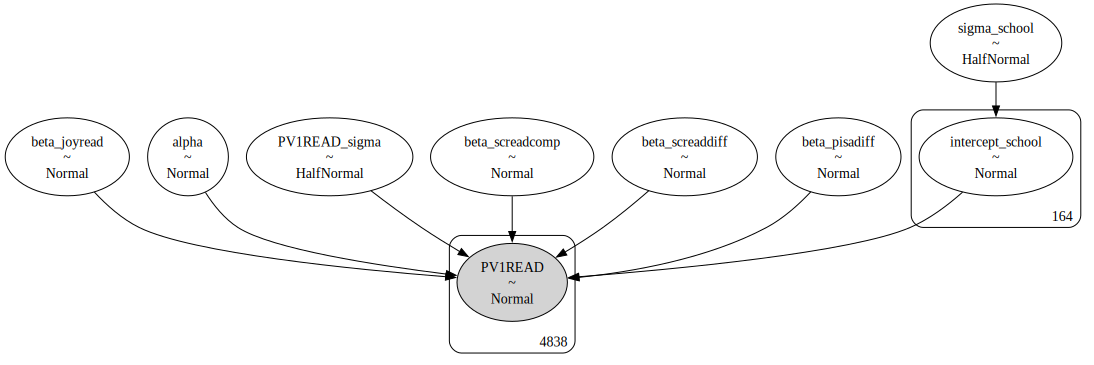

In [6]:
#PV1READ ~ JOYREAD + PISADIFF + SCREADCOMP + SCREADDIFF + (1|SchoolID)
# Create the model
with pm.Model() as model2:
    # Priors
    alpha = pm.Normal('alpha', mu=0, sigma=100)  # Intercept
    beta_joyread = pm.Normal('beta_joyread', mu=np.mean(PISA2018["JOYREAD"]), sigma=np.std(PISA2018["JOYREAD"]))  # Coefficient for JOYREAD
    beta_pisadiff = pm.Normal('beta_pisadiff', mu=0, sigma=100)  # Coefficient for PISADIFF
    beta_screadcomp = pm.Normal('beta_screadcomp', mu=np.mean(PISA2018["SCREADCOMP"]), sigma=10)  # Coefficient for SCREADCOMP
    beta_screaddiff = pm.Normal('beta_screaddiff', mu=np.mean(PISA2018["SCREADDIFF"]), sigma=np.std(PISA2018["SCREADDIFF"]))  # Coefficient for SCREADDIFF

    # Random effects for SchoolID
    sigma_school = pm.HalfNormal('sigma_school', sigma=100)
    intercept_school = pm.Normal('intercept_school', mu=0, sigma=sigma_school, shape=len(PISA2018["SchoolID"].unique()))

    # Likelihood equation
    PV1READ_mu = alpha + beta_joyread * PISA2018['JOYREAD'] + beta_pisadiff * PISA2018['PISADIFF'] + beta_screadcomp * PISA2018['SCREADCOMP']\
        + beta_screaddiff * PISA2018['SCREADDIFF']  + intercept_school[PISA2018['SchoolID'].cat.codes]
    PV1READ_sigma = pm.HalfNormal('PV1READ_sigma', sigma=100)
    PV1READ = pm.Normal('PV1READ', mu=PV1READ_mu, sigma=PV1READ_sigma, observed=PISA2018['PV1READ'])
    

# Sample from the posterior distribution
with model2:
    trace = pm.sample(1000, tune=2000)


# Creating the PV1MATH predictions using the model, and calculating the R^2 score and MSE as metrics of accuracy

# Making predictions on the training data
with model2:
    post_pred = pm.sample_posterior_predictive(trace, model=model2)
pred = post_pred.posterior_predictive["PV1READ"].mean(dim=["chain", "draw"])

# Printi7ng the accuracy metrics
print(f'The R^2 score is: {r2_score(PISA2018["PV1READ"], pred)}')
print(f'The MSE is: {mean_squared_error(PISA2018["PV1READ"], pred)}')

# Plotting a visualization of the model itself
pm.model_graph.model_to_graphviz(model2)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta_metasum, beta_gfofail, beta_mastgoal, beta_swbp, beta_workmast, beta_adaptivity, beta_compete, sigma_school, intercept_school, PV1READ_sigma]


Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 2298 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
Chain 0 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Sampling: [PV1READ]


The R^2 score is: 0.2738664916777487
The MSE is: 8539.350177922664


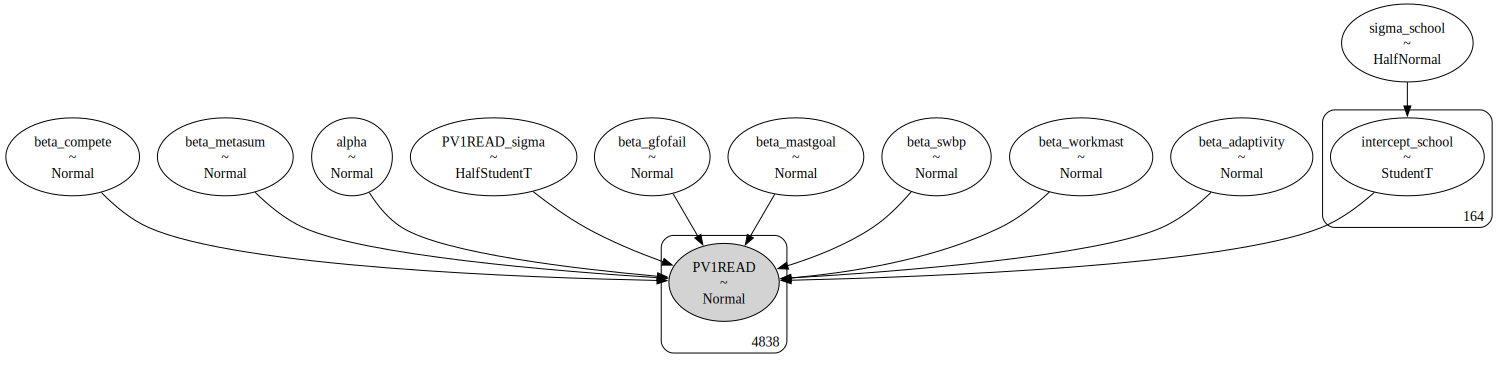

In [7]:
#PV1READ ~ METASUM + GFOFAIL + MASTGOAL + SWBP + WORKMAST + ADAPTIVITY + COMPETE + (1|SchoolID) 
# Create the model
with pm.Model() as model3:
    # Priors
    alpha = pm.Normal('alpha', mu=0, sigma=100)  # Intercept
    beta_metasum = pm.Normal('beta_metasum', mu=np.mean(PISA2018["METASUM"]), sigma=np.std(PISA2018["METASUM"]))  # Coefficient for METASUM
    beta_gfofail = pm.Normal('beta_gfofail', mu=0, sigma=100)  # Coefficient for GFOFAIL
    beta_mastgoal = pm.Normal('beta_mastgoal', mu=np.mean(PISA2018["MASTGOAL"]), sigma=10)  # Coefficient for MASTGOAL
    beta_swbp = pm.Normal('beta_swbp', mu=0, sigma=100)  # Coefficient for SWBP
    beta_workmast = pm.Normal('beta_workmast', mu=np.mean(PISA2018["WORKMAST"]), sigma=10)  # Coefficient for WORKMAST
    beta_adaptivity = pm.Normal('beta_adaptivity', mu=np.mean(PISA2018["ADAPTIVITY"]), sigma=100)  # Coefficient for ADAPTIVITY
    beta_compete = pm.Normal('beta_compete', mu=np.mean(PISA2018["COMPETE"]), sigma=np.std(PISA2018["COMPETE"]))  # Coefficient for COMPETE

    # Random effects for SchoolID
    sigma_school = pm.HalfNormal('sigma_school', sigma=100)
    intercept_school = pm.StudentT('intercept_school', nu = 1, mu=0, sigma=sigma_school, shape=len(PISA2018["SchoolID"].unique()))

    # Likelihood equation
    PV1READ_mu = alpha + beta_metasum * PISA2018['METASUM'] + beta_gfofail * PISA2018['GFOFAIL'] + beta_mastgoal * PISA2018['MASTGOAL']\
        + beta_swbp * PISA2018['SWBP'] + beta_workmast * PISA2018['WORKMAST'] + beta_adaptivity * PISA2018['ADAPTIVITY']\
        + beta_compete * PISA2018['COMPETE']  + intercept_school[PISA2018['SchoolID'].cat.codes]
    PV1READ_sigma = pm.HalfStudentT('PV1READ_sigma', nu = 10, sigma=100)
    PV1READ = pm.Normal('PV1READ', mu=PV1READ_mu, sigma=PV1READ_sigma, observed=PISA2018['PV1READ'])
    

# Sample from the posterior distribution
with model3:
    trace = pm.sample(1000, tune=2000)


# Creating the PV1MATH predictions using the model, and calculating the R^2 score and MSE as metrics of accuracy

# Making predictions on the training data
with model3:
    post_pred = pm.sample_posterior_predictive(trace, model=model3)
pred = post_pred.posterior_predictive["PV1READ"].mean(dim=["chain", "draw"])

# Printing the accuracy metrics
print(f'The R^2 score is: {r2_score(PISA2018["PV1READ"], pred)}')
print(f'The MSE is: {mean_squared_error(PISA2018["PV1READ"], pred)}')

# Plotting a visualization of the model itself
pm.model_graph.model_to_graphviz(model3)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta_perfeed, beta_teachint, beta_belong, sigma_school, sigma_teachint, intercept_school, random_teachint, PV1READ_sigma]


Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 110 seconds.
Sampling: [PV1READ]


The R^2 score is: 0.22968069400024071
The MSE is: 9058.976382931278


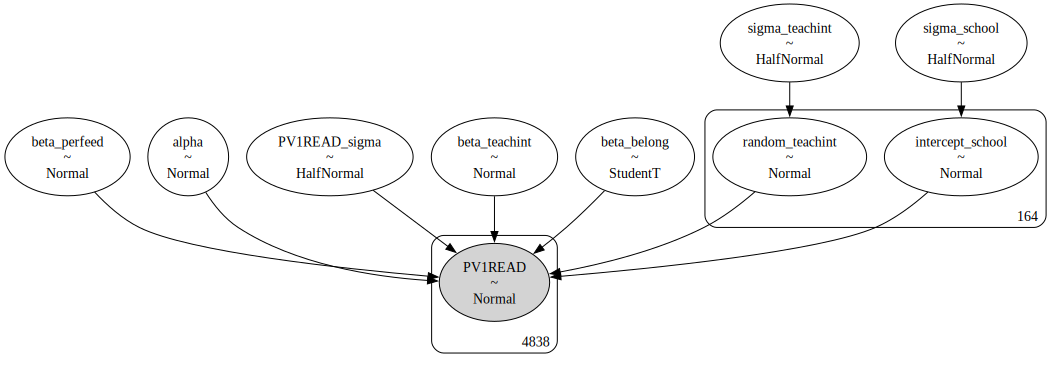

In [12]:
#PV1READ ~ PERFEED + TEACHINT + BELONG + (1 + TEACHINT | SchoolID)

# Create the model
with pm.Model() as model1:
    # Priors
    alpha = pm.Normal('alpha', mu=0, sigma=100)  # Intercept
    beta_perfeed = pm.Normal('beta_perfeed', mu = np.mean(PISA2018["PERFEED"]), sigma = np.std(PISA2018["PERFEED"]))  # Coefficient for PERFEED
    beta_teachint = pm.Normal('beta_teachint', mu=np.mean(PISA2018["TEACHINT"]), sigma = np.std(PISA2018["TEACHINT"]))  # Coefficient for TEACHINT
    beta_belong = pm.StudentT('beta_belong', nu = 1, mu=np.mean(PISA2018["BELONG"]), sigma=100)  # Coefficient for BELONG

    # Random effects for SchoolID
    #sigma_school = pm.HalfCauchy('sigma_school', beta=10)
    sigma_school = pm.HalfNormal('sigma_school', sigma=100)
    sigma_teachint = pm.HalfNormal('sigma_teachint', sigma=100)
    intercept_school = pm.Normal('intercept_school', mu=0, sigma=sigma_school, shape=len(PISA2018["SchoolID"].unique()))
    random_teachint = pm.Normal('random_teachint', mu=0, sigma=sigma_teachint, shape=len(PISA2018["SchoolID"].unique()))

    # Likelihood equation
    PV1READ_mu = alpha + beta_perfeed * PISA2018['PERFEED'] + beta_teachint * PISA2018['TEACHINT'] + beta_belong * PISA2018['BELONG']\
        + random_teachint[PISA2018['SchoolID'].cat.codes] * PISA2018['ICTRES']  + intercept_school[PISA2018['SchoolID'].cat.codes]
    PV1READ_sigma = pm.HalfNormal('PV1READ_sigma', sigma=100)
    PV1READ = pm.Normal('PV1READ', mu=PV1READ_mu, sigma=PV1READ_sigma, observed=PISA2018['PV1READ'])
    

# Sample from the posterior distribution
with model1:
    trace = pm.sample(1000, tune=2000)

    
# Creating the PV1MATH predictions using the model, and calculating the R^2 score and MSE as metrics of accuracy

# Making predictions on the training data
with model1:
    post_pred = pm.sample_posterior_predictive(trace, model=model1)
pred = post_pred.posterior_predictive["PV1READ"].mean(dim=["chain", "draw"])

# Printing the accuracy metrics
print(f'The R^2 score is: {r2_score(PISA2018["PV1READ"], pred)}')
print(f'The MSE is: {mean_squared_error(PISA2018["PV1READ"], pred)}')

# Plotting a visualization of the model itself
pm.model_graph.model_to_graphviz(model1)